In [6]:
%cd /tmp

![ ! -d deformable_detr ] && git clone https://github.com/fundamentalvision/Deformable-DETR.git deformable_detr
!pip install -r deformable_detr/requirements.txt
%cd deformable_detr/models/ops/
! ./make.sh

!pip install gdown
!gdown --id 1nDWZWHuRwtwGden77NLM9JoWe-YisJnA

/tmp
/tmp/deformable_detr/models/ops
running build
running build_py
running build_ext
/usr/local/lib/python3.8/dist-packages/torch/utils/cpp_extension.py:813: UserWarning: The detected CUDA version (11.1) has a minor version mismatch with the version that was used to compile PyTorch (11.6). Most likely this shouldn't be a problem.
  warnings.warn(CUDA_MISMATCH_WARN.format(cuda_str_version, torch.version.cuda))
building 'MultiScaleDeformableAttention' extension
Emitting ninja build file /tmp/deformable_detr/models/ops/build/temp.linux-x86_64-3.8/build.ninja...
Compiling objects...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
ninja: no work to do.
x86_64-linux-gnu-g++ -pthread -shared -Wl,-O1 -Wl,-Bsymbolic-functions -Wl,-Bsymbolic-functions -Wl,-z,relro -g -fwrapv -O2 -Wl,-Bsymbolic-functions -Wl,-z,relro -g -fwrapv -O2 -g -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 /tmp/de

In [3]:
import argparse
import sys
# sys.path.append('/tmp/detr/')
sys.path.append('/root/krishneel/Documents/research/deformable_detr/')

import torch
import numpy as np
from PIL import Image
from torchvision import transforms as T
import matplotlib.pyplot as plt

from models import build_model
from main import get_args_parser
from util.misc import nested_tensor_from_tensor_list
from datasets.coco import make_coco_transforms

In [13]:
parser = argparse.ArgumentParser('DETR training and evaluation script', parents=[get_args_parser()]) 
inputs = ['--resume', '/tmp/r50_deformable_detr-checkpoint.pth', '--device', 'cuda:0', '--no_aux_loss']
args = parser.parse_args(inputs)

model, _, postprocessors = build_model(args)

model.eval()
model.to(args.device)

weights = torch.load(args.resume)
model.load_state_dict(weights['model'], strict=True)

# preprocessng = T.Compose([T.ToTensor(),])
preprocessng = make_coco_transforms('val')

In [18]:
path = '/root/krishneel/Downloads/bus.jpg'
image = Image.open(path)

with torch.no_grad():
    x, _ = preprocessng(image, None)
    x = x.to(args.device).unsqueeze(0)
    x = nested_tensor_from_tensor_list(x)
    y = model(x)
    
im_shape = torch.FloatTensor([image.size[::-1]]).to(args.device)
predict = postprocessors['bbox'](y, im_shape)[0]

/root/krishneel/Documents/research/deformable_detr/models/position_encoding.py:49: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  dim_t = self.temperature ** (2 * (dim_t // 2) / self.num_pos_feats)
/root/krishneel/Documents/research/deformable_detr/models/deformable_detr.py:414: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  topk_boxes 

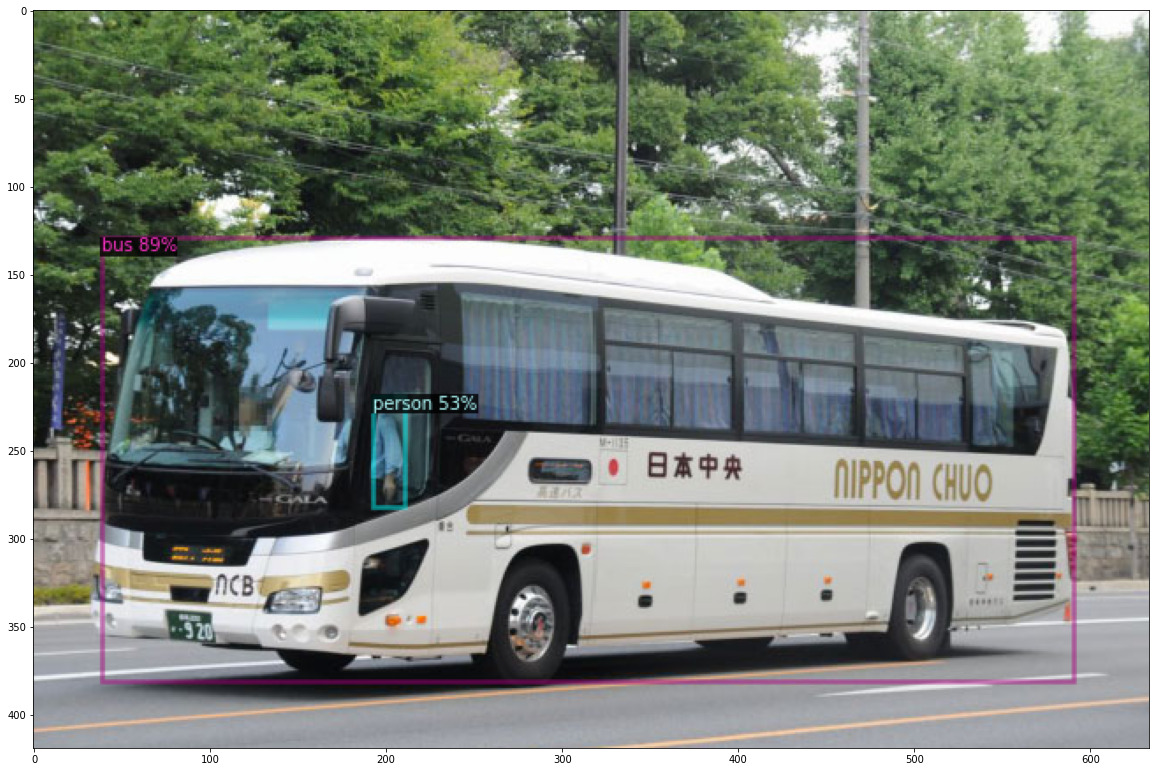

In [19]:
from detectron2.utils.visualizer import Visualizer
from detectron2.structures import Instances
from detectron2.data import MetadataCatalog

scores = predict['scores'].cpu().numpy()
bboxes = predict['boxes'].cpu().numpy()
labels = predict['labels'].cpu().numpy() - 1

indices = np.where(scores > 0.5)

instances = Instances(image.size)
instances.set('scores', scores[indices])
instances.set('pred_boxes', bboxes[indices])
instances.set('pred_classes', labels[indices])

metadata = MetadataCatalog.get('coco_2017_train')
viz = Visualizer(image, metadata)
viz.draw_instance_predictions(instances)
im = viz.get_output().get_image()

plt.rcParams['figure.figsize'] = [20, 16]
plt.imshow(im)

In [22]:
model.transformer.decoder.layers[0]


DeformableTransformerDecoderLayer(
  (cross_attn): MSDeformAttn(
    (sampling_offsets): Linear(in_features=256, out_features=256, bias=True)
    (attention_weights): Linear(in_features=256, out_features=128, bias=True)
    (value_proj): Linear(in_features=256, out_features=256, bias=True)
    (output_proj): Linear(in_features=256, out_features=256, bias=True)
  )
  (dropout1): Dropout(p=0.1, inplace=False)
  (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
  )
  (dropout2): Dropout(p=0.1, inplace=False)
  (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (linear1): Linear(in_features=256, out_features=1024, bias=True)
  (dropout3): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=1024, out_features=256, bias=True)
  (dropout4): Dropout(p=0.1, inplace=False)
  (norm3): LayerNorm((256,), eps=1e-05, elementwise_affine=T